In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [2]:
# Carrega dados do Breast Cancer
data = load_breast_cancer()
X = data.data
y = data.target  # 0 = maligno, 1 = benigno

# Normaliza os dados
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [3]:
# Função RBF gaussiana
def rbf(X, centers, sigma):
    dist = cdist(X, centers, 'euclidean')
    return np.exp(-dist**2 / (2 * sigma**2))

In [4]:
# Testa diferentes números de centros
center_options = [2, 5, 10, 20, 30, 40]
results = {}

folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for k in center_options:
    fold_errors = []
    for train_idx, test_idx in folds.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Aplica k-means nos dados de treino
        kmeans = KMeans(n_clusters=k, random_state=0).fit(X_train)
        centers = kmeans.cluster_centers_

        # Calcula sigma (média das distâncias entre centros)
        sigma = np.mean(cdist(centers, centers))

        # Obtém as ativações da camada escondida
        Phi_train = rbf(X_train, centers, sigma)
        Phi_test = rbf(X_test, centers, sigma)

        # Camada de saída: regressão logística
        clf = LogisticRegression(max_iter=500)
        clf.fit(Phi_train, y_train)
        y_pred = clf.predict(Phi_test)

        # Erro percentual
        error = 100 * (1 - accuracy_score(y_test, y_pred))
        fold_errors.append(error)

    results[k] = {
        "media": np.mean(fold_errors),
        "desvio": np.std(fold_errors),
        "todos": fold_errors
    }

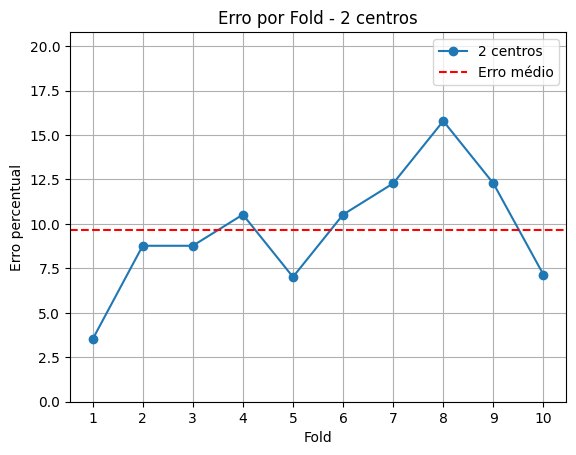

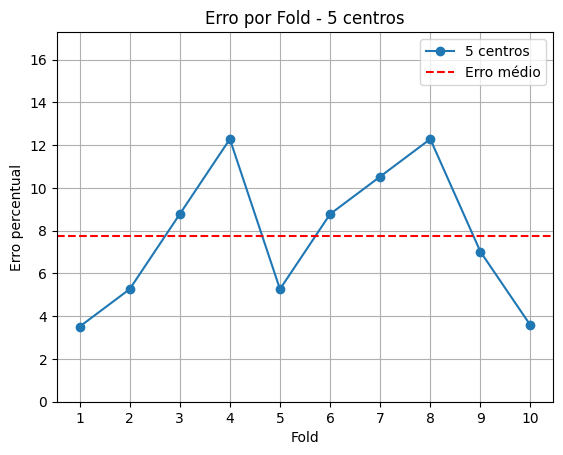

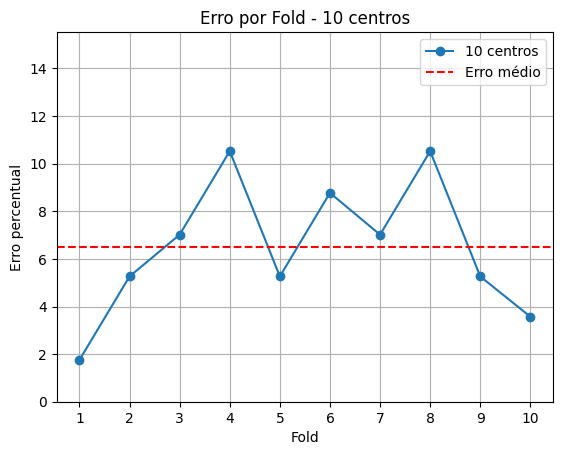

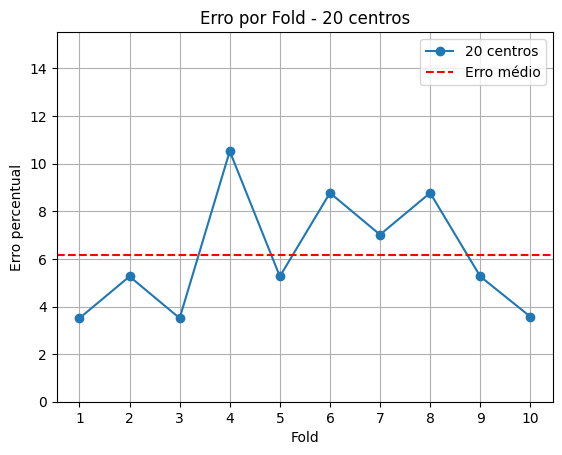

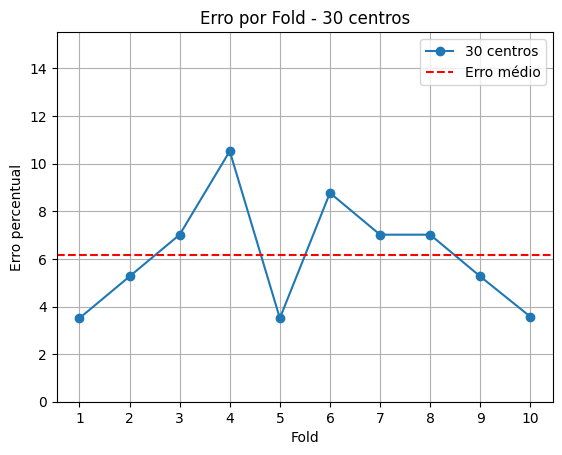

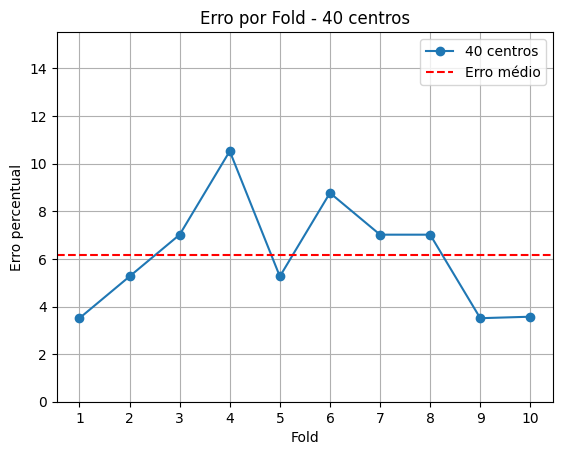

In [11]:
# Gráficos por fold para cada valor de k
for k in results:
    fold_errors = results[k]["todos"]
    plt.figure()
    plt.plot(range(1, 11), fold_errors, marker='o', linestyle='-', label=f'{k} centros')
    plt.axhline(np.mean(fold_errors), color='red', linestyle='--', label='Erro médio')
    plt.title(f'Erro por Fold - {k} centros')
    plt.xlabel('Fold')
    plt.ylabel('Erro percentual')
    plt.ylim(0, max(fold_errors) + 5)
    plt.xticks(range(1, 11))
    plt.grid(True)
    plt.legend()
    plt.show()

2 centros -> Erro médio: 9.66%, Desvio: 3.25%
5 centros -> Erro médio: 7.73%, Desvio: 3.15%
10 centros -> Erro médio: 6.50%, Desvio: 2.72%
20 centros -> Erro médio: 6.15%, Desvio: 2.38%
30 centros -> Erro médio: 6.15%, Desvio: 2.25%
40 centros -> Erro médio: 6.15%, Desvio: 2.25%


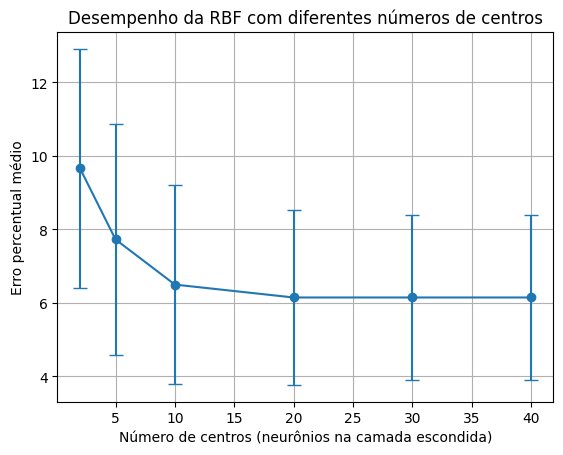

In [12]:
# Imprime resultados por número de centros
for k in results:
    print(f"{k} centros -> Erro médio: {results[k]['media']:.2f}%, Desvio: {results[k]['desvio']:.2f}%")

# Gráfico da média e do desvio
ks = list(results.keys())
means = [results[k]["media"] for k in ks]
stds = [results[k]["desvio"] for k in ks]

plt.errorbar(ks, means, yerr=stds, fmt='-o', capsize=5)
plt.xlabel('Número de centros (neurônios na camada escondida)')
plt.ylabel('Erro percentual médio')
plt.title('Desempenho da RBF com diferentes números de centros')
plt.grid(True)
plt.show()